# Semisup-learn self-training examples

Este notebook está constituido por una serie de ejemplos de semi-supervised self-learning usando el módulo semisup-learn https://github.com/tmadl/semisup-learn. Los ejemplos están adaptados de los libros "Python: Real World Machine Learning"
http://proquest.safaribooksonline.com.ezproxy.uned.es/book/programming/python/9781787123212, "Advanced Machine Learning with Python"
http://proquest.safaribooksonline.com.ezproxy.uned.es/book/programming/python/9781784398637 y "Python: Deeper Insights into Machine Learning"
http://proquest.safaribooksonline.com.ezproxy.uned.es/book/programming/python/9781787128576

Además del uso de SelfLearningModel con diferentes métodos de aprendizaje supervisado, muestra las diferencias entre que la hipótesis de "low density separation" se cumpla o no. Utiliza el dataset iris.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from IPython.display import Markdown
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from plot_utilities_svm import plot_confusion_matrix

from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from semisup_learn.frameworks.SelfLearning import SelfLearningModel

In [2]:
def plotROC(target, y_score, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(label_binarize(target, classes = [0,1]), y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(2):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [3]:
iris = datasets.load_iris()
display(Markdown(iris.DESCR))

Iris Plants Database
====================

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
    :Class Distribution: 33.3% for each of 3 classes.
    :Creator: R.A. Fisher
    :Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
    :Date: July, 1988

This is a copy of UCI ML iris datasets.
http://archive.ics.uci.edu/ml/datasets/Iris

The famous Iris database, first used by Sir R.A Fisher

This is perhaps the best known database to be found in the
pattern recognition literature.  Fisher's paper is a classic in the field and
is referenced frequently to this day.  (See Duda & Hart, for example.)  The
data set contains 3 classes of 50 instances each, where each class refers to a
type of iris plant.  One class is linearly separable from the other 2; the
latter are NOT linearly separable from each other.

References
----------
   - Fisher,R.A. "The use of multiple measurements in taxonomic problems"
     Annual Eugenics, 7, Part II, 179-188 (1936); also in "Contributions to
     Mathematical Statistics" (John Wiley, NY, 1950).
   - Duda,R.O., & Hart,P.E. (1973) Pattern Classification and Scene Analysis.
     (Q327.D83) John Wiley & Sons.  ISBN 0-471-22361-1.  See page 218.
   - Dasarathy, B.V. (1980) "Nosing Around the Neighborhood: A New System
     Structure and Classification Rule for Recognition in Partially Exposed
     Environments".  IEEE Transactions on Pattern Analysis and Machine
     Intelligence, Vol. PAMI-2, No. 1, 67-71.
   - Gates, G.W. (1972) "The Reduced Nearest Neighbor Rule".  IEEE Transactions
     on Information Theory, May 1972, 431-433.
   - See also: 1988 MLC Proceedings, 54-64.  Cheeseman et al"s AUTOCLASS II
     conceptual clustering system finds 3 classes in the data.
   - Many, many more ...


In [4]:
RANDOM_STATE = 21

class_names = iris.target_names

scaler = StandardScaler()

petal = True
if petal:
    X = scaler.fit_transform(iris.data[:,2:].astype(np.float32))
else:
    X = scaler.fit_transform(iris.data[:,:2].astype(np.float32))
    
ytrue = np.copy(iris.target)

high_density_sep = False

if high_density_sep:
    # setosa vs. versicolor y virginica
    ytrue[(ytrue==1) | (ytrue==2)] = 1
else:
    # virginica vs. setosa y versicolor
    ytrue[(ytrue==0) | (ytrue==1)] = 1
    ytrue[ytrue==2] = 0
    
num_classes = 2;    

labeled_percent = 0.03 # 0.1. Si es < 0.03 (labeled_N < 4) self-learning KNN falla
labeled_N = int(round(ytrue.shape[0] * labeled_percent)) # 20
if labeled_N < num_classes:
    labeled_N = num_classes
ys = np.array([-1]*len(ytrue)) # -1 denotes unlabeled point
n_points_0 = labeled_N/2
n_points_1 = labeled_N/2

if n_points_0 > np.where(ytrue == 0)[0].shape[0] or n_points_1 > np.where(ytrue == 1)[0].shape[0]:
    n_points_0 = np.where(ytrue == 0)[0].shape[0] - 1 # -1 tiene que haber algún unlabeled para que funcione
    n_points_1 = np.where(ytrue == 1)[0].shape[0] - 1
random.seed(RANDOM_STATE)
random_labeled_points = random.sample(np.where(ytrue == 0)[0], n_points_0)+\
                        random.sample(np.where(ytrue == 1)[0], n_points_1)
ys[random_labeled_points] = ytrue[random_labeled_points]
yl = ys[random_labeled_points]
Xl = X[random_labeled_points]

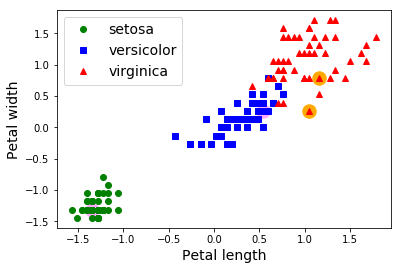

In [5]:
y = iris["target"]
        
x_set = X[y==0]
x_vers = X[y==1]
x_virg = X[y==2]
plt.plot(x_set[:,0], x_set[:,1], 'go', label=class_names[0]) # green circle
plt.plot(x_vers[:,0], x_vers[:,1], 'bs', label=class_names[1]) # blue square
plt.plot(x_virg[:,0], x_virg[:,1], 'r^', label=class_names[2]) # red triangle
if petal:
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
else:
    plt.xlabel("Sepal length", fontsize=14)
    plt.ylabel("Sepal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

X_label_0 = Xl[yl == 0]
X_label_1 = Xl[yl == 1]
plt.scatter(X_label_0[:, 0], X_label_0[:, 1], s=180, facecolors='#FFAA00')
plt.scatter(X_label_1[:, 0], X_label_1[:, 1], s=180, facecolors='#FFAAFF')
    
plt.show()

In [6]:
class_names = np.array(class_names, dtype='object') # Para poder cambiar el tamaño de los elementos
if high_density_sep:
    class_names[1] = class_names[1] + '-' + class_names[2]
else:    
    class_names[1] = class_names[0]+class_names[1]
    class_names[0] = class_names[2]
class_names = np.resize(class_names, 2)

('supervised SGD score', 0.94)
('self-learning SDG score', 0.9533333333333334)

Normalized confusion matrix
[[0.86 0.14]
 [0.   1.  ]]
('Accuracy = ', 0.9533333333333334)
('Precision = ', 0.9345794392523364)
('Sensitivity = ', 1.0)
('F1 = ', 0.966183574879227)

Normalized confusion matrix
[[0.86 0.14]
 [0.   1.  ]]
('Accuracy = ', 0.9533333333333334)
('Precision = ', 0.9345794392523364)
('Sensitivity = ', 1.0)
('F1 = ', 0.966183574879227)


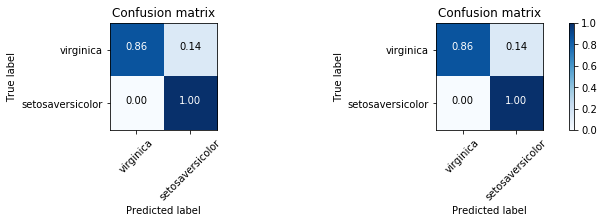

In [7]:
basemodel = SGDClassifier(loss='log', penalty='l1', random_state=RANDOM_STATE, max_iter = 1000) # max_iter=1000

basemodel.fit(Xl, yl)
# basemodel.fit(X, ytrue)
print ("supervised SGD score", basemodel.score(X, ytrue))

ssmodel = SelfLearningModel(basemodel)
ssmodel.fit(X, ys)
y_score = ssmodel.predict(X)
print("self-learning SDG score", ssmodel.score(X, ytrue))

print('')

plt.figure(figsize=(12,3.2))
plt.subplot(121)
y_score_base = basemodel.predict(X)
cm1 = confusion_matrix(ytrue, y_score_base)
plot_confusion_matrix(plt, np, cm1, class_names)

print('')
plt.subplot(122)
cm2 = confusion_matrix(ytrue, y_score)
plot_confusion_matrix(plt, np, cm2, class_names)

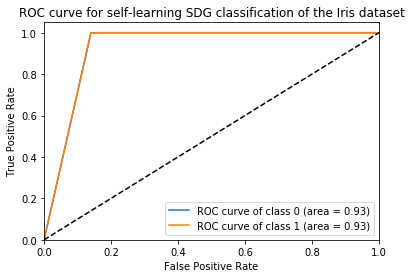

In [8]:
title='ROC curve for self-learning SDG classification of the Iris dataset'
plotROC(ytrue, y_score, title)

('supervised SVC score', 0.7)
('self-learning SVC score', 0.7)

Normalized confusion matrix
[[1.   0.  ]
 [0.45 0.55]]
('Accuracy = ', 0.7)
('Precision = ', 1.0)
('Sensitivity = ', 0.55)
('F1 = ', 0.7096774193548387)

Normalized confusion matrix
[[1.   0.  ]
 [0.45 0.55]]
('Accuracy = ', 0.7)
('Precision = ', 1.0)
('Sensitivity = ', 0.55)
('F1 = ', 0.7096774193548387)


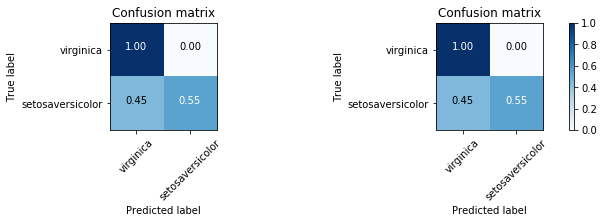

In [9]:
basemodel2 = SVC(kernel='linear', C=1, probability=True, random_state=RANDOM_STATE) # probability=True para SelfLearningModel.predict_proba

basemodel2.fit(Xl, yl)
# basemodel2.fit(X, ytrue)
print("supervised SVC score", basemodel2.score(X, ytrue))

ssmodel2 = SelfLearningModel(basemodel2)
ssmodel2.fit(X, ys)
y_score2 = ssmodel2.predict(X)
print("self-learning SVC score", ssmodel2.score(X, ytrue))

print('')

plt.figure(figsize=(12,3.2))
plt.subplot(121)
y_score_base = basemodel2.predict(X)
cm1 = confusion_matrix(ytrue, y_score_base)
plot_confusion_matrix(plt, np, cm1, class_names)

print('')

plt.subplot(122)
cm2 = confusion_matrix(ytrue, y_score2)
plot_confusion_matrix(plt, np, cm2, class_names)

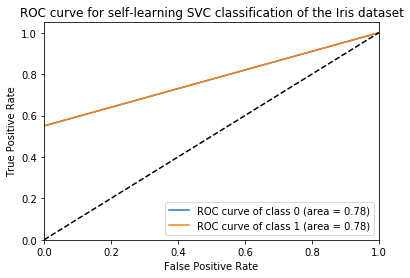

In [10]:
title = 'ROC curve for self-learning SVC classification of the Iris dataset'
plotROC(ytrue, y_score2, title)

('supervised KNN score', 0.6733333333333333)
('self-learning KNN score', 0.9666666666666667)

Normalized confusion matrix
[[1.   0.  ]
 [0.49 0.51]]
('Accuracy = ', 0.6733333333333333)
('Precision = ', 1.0)
('Sensitivity = ', 0.51)
('F1 = ', 0.6754966887417219)

Normalized confusion matrix
[[1.   0.  ]
 [0.05 0.95]]
('Accuracy = ', 0.9666666666666667)
('Precision = ', 1.0)
('Sensitivity = ', 0.95)
('F1 = ', 0.9743589743589743)


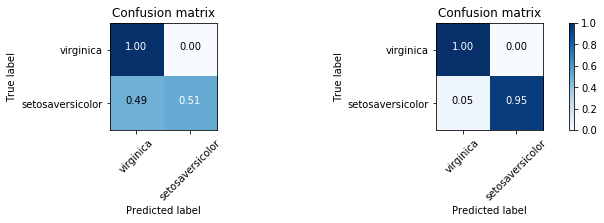

In [11]:
basemodel3 = KNeighborsClassifier(n_neighbors = 2) # n_neighbors <= num. clases

basemodel3.fit(Xl, yl)
# basemodel3.fit(X, ytrue)
y_score_base = basemodel3.predict(X)
cm1 = confusion_matrix(ytrue, y_score_base)
print("supervised KNN score", basemodel3.score(X, ytrue))

ssmodel3 = SelfLearningModel(basemodel3)
ssmodel3.fit(X, ys)
#print("this is the fitted thing", ssmodel3)
y_score3 = ssmodel3.predict(X)
cm2 = confusion_matrix(ytrue, y_score3)
print("self-learning KNN score", ssmodel3.score(X, ytrue))

print('')

plt.figure(figsize=(12,3.2))
plt.subplot(121)

plot_confusion_matrix(plt, np, cm1, class_names)

print('')

plt.subplot(122)
plot_confusion_matrix(plt, np, cm2, class_names)

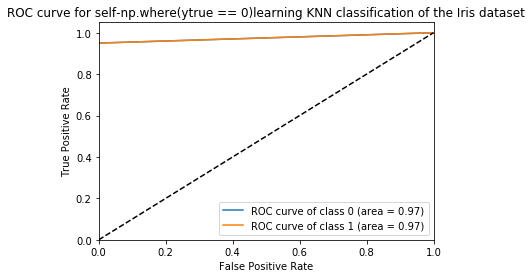

In [12]:
title = 'ROC curve for self-np.where(ytrue == 0)learning KNN classification of the Iris dataset'
plotROC(ytrue, y_score3, title)

In [13]:
random_labeled_points

[108, 134, 63, 47]

In [14]:
y_score_base

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])